In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors
from tqdm.auto import tqdm
from time import sleep
import torchvision
import torch_geometric.nn as pyg_nn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score


cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
features_covid = torch.load(r'C:\Users\hvard\Desktop\Neeraj_work\Neeraj_work\covid.pt', map_location=torch.device('cpu'))
features_noncovid = torch.load(r'C:\Users\hvard\Desktop\Neeraj_work\Neeraj_work\health.pt',map_location=torch.device('cpu'))

In [ ]:
train_labels = torch.zeros((features_covid.shape[0]))
test_labels = torch.ones((features_noncovid.shape[0]))

In [37]:
train_labels.shape

torch.Size([1252])

In [6]:
train_feats = []
train_label = []
for i in range(250,len(test_labels)):
    train_feats.append(features_covid[i])
    train_feats.append(features_noncovid[i])
    train_label.append(train_labels[i])
    train_label.append(test_labels[i])

In [7]:
test_feats = []
test_label = []

In [8]:
for i in range(0,250):
    test_feats.append(features_covid[i])
    test_feats.append(features_noncovid[i])
    test_label.append(train_labels[i])
    test_label.append(test_labels[i])

In [9]:
train_feats = torch.stack(train_feats)
train_label = torch.stack(train_label)
test_feats = torch.stack(test_feats)
test_label = torch.stack(test_label)

In [10]:
features_train = train_feats.unsqueeze(1)
features_test = test_feats.unsqueeze(1)

In [11]:
train_label = train_label.to(torch.long)
test_label = test_label.to(torch.long)

In [12]:
features_train.shape

torch.Size([1958, 1, 128])

In [13]:
from torch.utils.data import Dataset, DataLoader

class FeatureDataset(Dataset):
  """
  This is a custom dataset class to generate feature dataset to load into models
  """
  def __init__(self, X, Y):
    features = []
    labels = []
    
    for i in range(0,X.shape[0]):
      temp = X[i]
      features.append(temp)
      s = torch.stack(features)
      self.X = s
      temp1 = Y[i]
      labels.append(temp1)
      t = torch.stack(labels)
      self.Y = t

    
    if len(self.X) != len(self.Y):
        raise Exception("The length of X does not match the length of Y")

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    # note that this isn't randomly selecting. It's a simple get a single item that represents an x and y
    x = self.X[index]
    y = self.Y[index]

    return x, y

In [15]:
# Learning rate parameters
BASE_LR = 0.0001
EPOCH_DECAY = 5 # number of epochs after which the Learning rate is decayed exponentially.
DECAY_WEIGHT = 0.5 # factor by which the learning rate is reduced.


# DATASET INFO
NUM_CLASSES = 2 # set the number of classes in your dataset
VALID_SPLIT = 0.8

# DATALOADER PROPERTIES
BATCH_SIZE = 1024 # Set as high as possible. If you keep it too high, you'll get an out of memory error.

In [17]:
#dataset for train and val
dataset = FeatureDataset(features_train, train_label)
dataset

In [18]:
torch.save(dataset,'features_dataset_CTScans.pt')

In [19]:
#dataset for test
test_data = FeatureDataset(features_test,test_label)
test_loader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True)
print(test_loader)

In [20]:
len(dataset)

1958

In [21]:
SIZE =0.8
a = int(SIZE * len(dataset))
b = len(dataset)- a
train_data, val_data = torch.utils.data.random_split(dataset,[a,b])
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE,shuffle=True)
print(len(train_loader),len(val_loader))

2 1


In [22]:
#k = 21

def nearestneighbours(features,k):
    neighbour = NearestNeighbors(n_neighbors=k)
    features = features.cpu().detach().numpy()
    features = features.squeeze()
    neighbour.fit(features)
    temp_matrix = neighbour.kneighbors_graph(features)
    temp_matrix = temp_matrix.toarray()
    temp_matrix = torch.from_numpy(temp_matrix)
    temp_matrix = temp_matrix.to(device)

    return temp_matrix

In [23]:
def edge_finder(matrix):
    matrix = matrix.cpu()
    m = matrix.numpy().squeeze()
    edge = []
    
    for i in range(0,matrix.shape[0]):
        for j in range(0,matrix.shape[0]):
            if(m[i][j] == 1):
                x = i,j
                edge.append(x)

    edge = np.array(edge)
    edge  = torch.from_numpy(edge)
    edge = edge.T
    edge = edge.to(torch.long) 
    edge = edge.to(device)   
    return(edge)

In [24]:
class GNN(nn.Module):
    
    def __init__(self, c_in, c_out):
        super().__init__()
        print(c_in,c_out)
        self.projection = nn.Linear(c_in, c_out)
        self.fc1 = pyg_nn.GCNConv(128, 64)
        self.fc2 = pyg_nn.GCNConv(64, 32)
        self.fc3 = pyg_nn.GCNConv(32,16)
        self.fc4 = pyg_nn.GCNConv(16, 2)
        
    
    def forward(self, node_feats, adj_matrix, edges, flag):
        """
        Inputs:
            node_feats - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections. 
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        if(flag == 1):
        # Num neighbours = number of incoming edges
            num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
            #print(node_feats.shape)
            #batch = node_feats.shape[0]
            node_feats = self.projection(node_feats.float())
            node_feats = torch.matmul(adj_matrix.float(), node_feats)
            node_feats = node_feats / num_neighbours

            return node_feats

        else:
            x = self.fc1(node_feats.float(), edges)
            x = F.relu(x)
            x = F.dropout(x,p=0.5)
            x = self.fc2(x, edges)
            x = F.relu(x)
            x = F.dropout(x,p=0.5)
            x = self.fc3(x, edges)
            x = F.relu(x)
            x = F.dropout(x,p=0.5)
            x = self.fc4(x,edges)
            out = F.softmax(x, dim=2)
            
            #print("This is out",out)
            return out 

    def loss(self, pred, label):
        loss1 = nn.CrossEntropyLoss()
        return loss1(pred, label)

In [25]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion, k
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'k':k
                }, 'best_model_features.pth')

In [26]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'final_model_features.pth')

In [27]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='dotted', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='dotted', 
        label='validataion accuracy'
    )
    #plt.ylim([60,100])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.legend()
    plt.savefig('accuracy.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='dotted', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='dotted', 
        label='validataion loss'
    )
    #plt.ylim([0,0.6])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss.png')
    plt.show()

In [28]:
gnn = GNN(c_in=features_train.shape[2], c_out=features_train.shape[2])
gnn.projection.weight.data = nn.init.xavier_uniform_(torch.rand(features_train.shape[2],features_train.shape[2]))
gnn.projection.bias.data = torch.rand(features_train.shape[2])
gnn

128 128


GNN(
  (projection): Linear(in_features=128, out_features=128, bias=True)
  (fc1): GCNConv(128, 64)
  (fc2): GCNConv(64, 32)
  (fc3): GCNConv(32, 16)
  (fc4): GCNConv(16, 2)
)

In [29]:
model = gnn
model = model.to(device)
# optimizer
optimizer_ft = optim.RMSprop(model.parameters(), lr=0.0001)
# loss function
criterion = nn.CrossEntropyLoss()
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
# initialize SaveBestModel class
save_best_model = SaveBestModel()
print(model)

27,410 total parameters.
GNN(
  (projection): Linear(in_features=128, out_features=128, bias=True)
  (fc1): GCNConv(128, 64)
  (fc2): GCNConv(64, 32)
  (fc3): GCNConv(32, 16)
  (fc4): GCNConv(16, 2)
)


In [30]:
# training
def train(model, trainloader, optimizer, criterion,k):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        features, labels = data
        features = features.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        features = features.squeeze()
        adj_matrix = nearestneighbours(features,k)
        adj_matrix = adj_matrix.to(device)
        edge = edge_finder(adj_matrix)
        
        
        feats = model(features.unsqueeze(0),adj_matrix.unsqueeze(0), edge, 1)
        outputs = model(feats, adj_matrix, edge, 0)
        outputs = outputs.squeeze()
        #outputs = outputs.to(torch.long)
        #outputs = model(image)
        # calculate the loss
        labels = labels.to(torch.long)
        loss = model.loss(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward(retain_graph=True)
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [31]:
# validation
def validate(model, testloader, criterion,k):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            features, labels = data
            features = features.to(device)
            labels = labels.to(device)
            # forward pass
            features = features.squeeze()
            adj_matrix = nearestneighbours(features,k)
            adj_matrix = adj_matrix.to(device)
            edge = edge_finder(adj_matrix)
            feats = model(features.unsqueeze(0), adj_matrix.unsqueeze(0), edge, 1)
            outputs = model(feats, adj_matrix, edge, 0)
            outputs = outputs.squeeze()
            #outputs = model(image)
            # forward pass
            #outputs = model(features)
            # calculate the loss
            labels = labels.to(torch.long)
            loss = model.loss(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

K =  3
[INFO]: Epoch 1 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


Training loss: 0.742, training acc: 51.980
Validation loss: 0.616, validation acc: 67.347

Best validation loss: 0.6164489984512329

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


Training loss: 0.584, training acc: 69.285
Validation loss: 0.523, validation acc: 77.296

Best validation loss: 0.5232938528060913

Saving best model for epoch: 2

--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


Training loss: 0.538, training acc: 76.501
Validation loss: 0.499, validation acc: 81.633

Best validation loss: 0.49865013360977173

Saving best model for epoch: 3

--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.27it/s]


Training loss: 0.497, training acc: 81.162
Validation loss: 0.456, validation acc: 85.714

Best validation loss: 0.4558311402797699

Saving best model for epoch: 4

--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


Training loss: 0.466, training acc: 82.056
Validation loss: 0.471, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


Training loss: 0.467, training acc: 84.483
Validation loss: 0.433, validation acc: 88.010

Best validation loss: 0.4329025149345398

Saving best model for epoch: 6

--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


Training loss: 0.446, training acc: 86.526
Validation loss: 0.430, validation acc: 88.776

Best validation loss: 0.42963793873786926

Saving best model for epoch: 7

--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


Training loss: 0.447, training acc: 85.888
Validation loss: 0.413, validation acc: 91.071

Best validation loss: 0.4132390320301056

Saving best model for epoch: 8

--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Training loss: 0.441, training acc: 86.462
Validation loss: 0.425, validation acc: 89.796
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


Training loss: 0.435, training acc: 87.356
Validation loss: 0.440, validation acc: 86.480
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


Training loss: 0.430, training acc: 86.909
Validation loss: 0.409, validation acc: 91.582

Best validation loss: 0.40907564759254456

Saving best model for epoch: 11

--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


Training loss: 0.434, training acc: 87.484
Validation loss: 0.413, validation acc: 90.306
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.21it/s]


Training loss: 0.428, training acc: 87.931
Validation loss: 0.405, validation acc: 91.837

Best validation loss: 0.405393123626709

Saving best model for epoch: 13

--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


Training loss: 0.431, training acc: 88.123
Validation loss: 0.406, validation acc: 91.327
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


Training loss: 0.433, training acc: 87.676
Validation loss: 0.414, validation acc: 89.796
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.54it/s]


Training loss: 0.434, training acc: 88.123
Validation loss: 0.404, validation acc: 92.092

Best validation loss: 0.4035138785839081

Saving best model for epoch: 16

--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


Training loss: 0.419, training acc: 88.506
Validation loss: 0.398, validation acc: 91.837

Best validation loss: 0.39810654520988464

Saving best model for epoch: 17

--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.20it/s]


Training loss: 0.423, training acc: 88.250
Validation loss: 0.416, validation acc: 89.286
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


Training loss: 0.424, training acc: 88.314
Validation loss: 0.392, validation acc: 92.347

Best validation loss: 0.3917636573314667

Saving best model for epoch: 19

--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


Training loss: 0.415, training acc: 89.272
Validation loss: 0.411, validation acc: 89.541
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


Training loss: 0.409, training acc: 89.655
Validation loss: 0.409, validation acc: 90.561
--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


Training loss: 0.406, training acc: 90.549
Validation loss: 0.397, validation acc: 92.347
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


Training loss: 0.419, training acc: 88.761
Validation loss: 0.398, validation acc: 91.582
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


Training loss: 0.421, training acc: 88.250
Validation loss: 0.393, validation acc: 92.092
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.55it/s]


Training loss: 0.418, training acc: 89.464
Validation loss: 0.389, validation acc: 92.092

Best validation loss: 0.38912662863731384

Saving best model for epoch: 25

--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


Training loss: 0.407, training acc: 89.783
Validation loss: 0.385, validation acc: 92.347

Best validation loss: 0.38464275002479553

Saving best model for epoch: 26

--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


Training loss: 0.412, training acc: 90.038
Validation loss: 0.395, validation acc: 91.582
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


Training loss: 0.414, training acc: 89.527
Validation loss: 0.410, validation acc: 90.561
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


Training loss: 0.415, training acc: 89.464
Validation loss: 0.395, validation acc: 91.327
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


Training loss: 0.403, training acc: 90.485
Validation loss: 0.386, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


Training loss: 0.408, training acc: 90.038
Validation loss: 0.388, validation acc: 91.837
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Training loss: 0.404, training acc: 90.230
Validation loss: 0.400, validation acc: 91.327
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


Training loss: 0.399, training acc: 91.060
Validation loss: 0.388, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


Training loss: 0.409, training acc: 90.230
Validation loss: 0.404, validation acc: 91.327
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


Training loss: 0.408, training acc: 89.974
Validation loss: 0.394, validation acc: 92.092
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


Training loss: 0.410, training acc: 89.847
Validation loss: 0.394, validation acc: 92.092
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


Training loss: 0.409, training acc: 90.102
Validation loss: 0.398, validation acc: 91.582
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.20it/s]


Training loss: 0.405, training acc: 90.421
Validation loss: 0.397, validation acc: 90.816
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


Training loss: 0.412, training acc: 90.038
Validation loss: 0.384, validation acc: 93.112

Best validation loss: 0.38395461440086365

Saving best model for epoch: 39

--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


Training loss: 0.413, training acc: 89.527
Validation loss: 0.374, validation acc: 94.643

Best validation loss: 0.374233603477478

Saving best model for epoch: 40

--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


Training loss: 0.406, training acc: 90.166
Validation loss: 0.392, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


Training loss: 0.401, training acc: 90.677
Validation loss: 0.391, validation acc: 90.816
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


Training loss: 0.398, training acc: 90.932
Validation loss: 0.385, validation acc: 92.347
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


Training loss: 0.404, training acc: 89.591
Validation loss: 0.373, validation acc: 94.133

Best validation loss: 0.3725040853023529

Saving best model for epoch: 44

--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


Training loss: 0.407, training acc: 90.485
Validation loss: 0.383, validation acc: 92.857
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


Training loss: 0.406, training acc: 90.294
Validation loss: 0.379, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


Training loss: 0.407, training acc: 90.230
Validation loss: 0.400, validation acc: 90.561
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


Training loss: 0.408, training acc: 90.038
Validation loss: 0.391, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


Training loss: 0.398, training acc: 91.699
Validation loss: 0.387, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


Training loss: 0.398, training acc: 90.741
Validation loss: 0.391, validation acc: 91.327
--------------------------------------------------
Saving final model...


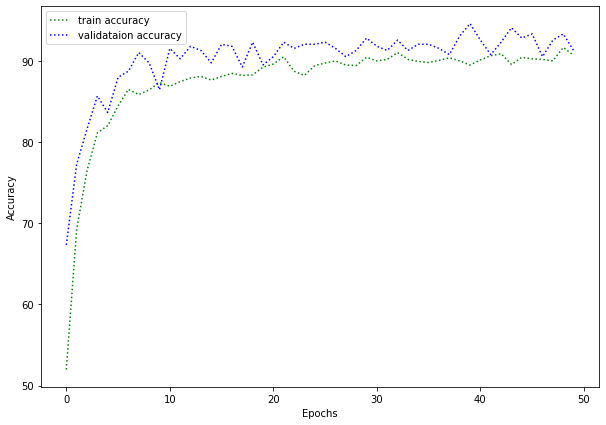

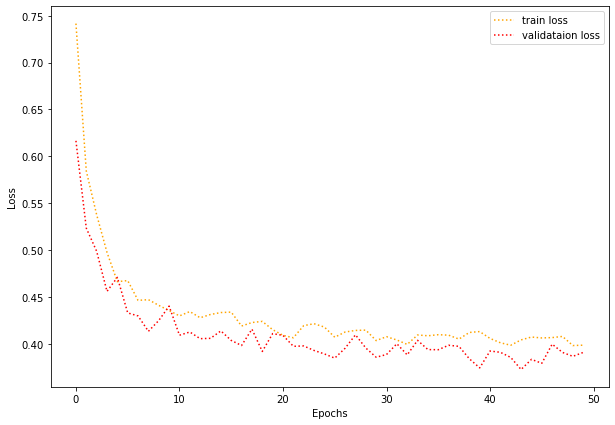

K =  5
[INFO]: Epoch 1 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


Training loss: 0.387, training acc: 92.209
Validation loss: 0.367, validation acc: 94.643

Best validation loss: 0.3669905364513397

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


Training loss: 0.391, training acc: 92.018
Validation loss: 0.370, validation acc: 94.388
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


Training loss: 0.387, training acc: 92.529
Validation loss: 0.368, validation acc: 94.643
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


Training loss: 0.393, training acc: 91.826
Validation loss: 0.376, validation acc: 94.133
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Training loss: 0.388, training acc: 91.954
Validation loss: 0.375, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


Training loss: 0.392, training acc: 91.315
Validation loss: 0.367, validation acc: 94.898

Best validation loss: 0.3668614327907562

Saving best model for epoch: 6

--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


Training loss: 0.392, training acc: 92.146
Validation loss: 0.373, validation acc: 94.643
--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


Training loss: 0.387, training acc: 92.209
Validation loss: 0.366, validation acc: 94.388

Best validation loss: 0.36584359407424927

Saving best model for epoch: 8

--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Training loss: 0.385, training acc: 92.146
Validation loss: 0.376, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


Training loss: 0.383, training acc: 92.018
Validation loss: 0.384, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Training loss: 0.385, training acc: 92.529
Validation loss: 0.361, validation acc: 95.408

Best validation loss: 0.3605859577655792

Saving best model for epoch: 11

--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


Training loss: 0.385, training acc: 92.018
Validation loss: 0.376, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Training loss: 0.392, training acc: 91.826
Validation loss: 0.364, validation acc: 94.388
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


Training loss: 0.391, training acc: 91.826
Validation loss: 0.363, validation acc: 94.643
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


Training loss: 0.386, training acc: 92.401
Validation loss: 0.380, validation acc: 92.602
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


Training loss: 0.386, training acc: 92.273
Validation loss: 0.370, validation acc: 93.878
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


Training loss: 0.389, training acc: 91.954
Validation loss: 0.378, validation acc: 93.878
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


Training loss: 0.382, training acc: 92.912
Validation loss: 0.373, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.47it/s]


Training loss: 0.387, training acc: 92.273
Validation loss: 0.374, validation acc: 93.878
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


Training loss: 0.387, training acc: 92.146
Validation loss: 0.370, validation acc: 94.643
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


Training loss: 0.389, training acc: 92.209
Validation loss: 0.370, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


Training loss: 0.385, training acc: 92.529
Validation loss: 0.361, validation acc: 95.663
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


Training loss: 0.386, training acc: 92.593
Validation loss: 0.366, validation acc: 94.388
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


Training loss: 0.386, training acc: 92.401
Validation loss: 0.369, validation acc: 94.388
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


Training loss: 0.386, training acc: 92.784
Validation loss: 0.376, validation acc: 93.367
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


Training loss: 0.389, training acc: 92.465
Validation loss: 0.372, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


Training loss: 0.387, training acc: 92.082
Validation loss: 0.375, validation acc: 93.112
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


Training loss: 0.387, training acc: 92.146
Validation loss: 0.372, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


Training loss: 0.387, training acc: 92.656
Validation loss: 0.372, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


Training loss: 0.386, training acc: 92.273
Validation loss: 0.366, validation acc: 94.643
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


Training loss: 0.388, training acc: 92.146
Validation loss: 0.370, validation acc: 94.388
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


Training loss: 0.381, training acc: 92.784
Validation loss: 0.371, validation acc: 93.622
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.39it/s]


Training loss: 0.386, training acc: 92.018
Validation loss: 0.362, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


Training loss: 0.386, training acc: 92.337
Validation loss: 0.369, validation acc: 94.898
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


Training loss: 0.387, training acc: 92.146
Validation loss: 0.365, validation acc: 94.898
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


Training loss: 0.386, training acc: 92.465
Validation loss: 0.369, validation acc: 94.133
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


Training loss: 0.388, training acc: 92.656
Validation loss: 0.366, validation acc: 94.898
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


Training loss: 0.387, training acc: 92.146
Validation loss: 0.370, validation acc: 94.388
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


Training loss: 0.380, training acc: 92.976
Validation loss: 0.369, validation acc: 94.388
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Training loss: 0.383, training acc: 92.529
Validation loss: 0.360, validation acc: 95.153

Best validation loss: 0.3604375123977661

Saving best model for epoch: 40

--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.59it/s]


Training loss: 0.385, training acc: 92.784
Validation loss: 0.367, validation acc: 94.898
--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


Training loss: 0.382, training acc: 92.401
Validation loss: 0.367, validation acc: 94.133
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


Training loss: 0.384, training acc: 92.784
Validation loss: 0.367, validation acc: 93.878
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.33it/s]


Training loss: 0.384, training acc: 92.720
Validation loss: 0.373, validation acc: 93.878
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


Training loss: 0.380, training acc: 93.487
Validation loss: 0.366, validation acc: 94.388
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


Training loss: 0.385, training acc: 92.848
Validation loss: 0.373, validation acc: 94.643
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


Training loss: 0.388, training acc: 91.954
Validation loss: 0.362, validation acc: 94.898
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.48it/s]


Training loss: 0.380, training acc: 93.295
Validation loss: 0.372, validation acc: 94.388
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.56it/s]


Training loss: 0.384, training acc: 92.337
Validation loss: 0.368, validation acc: 94.133
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


Training loss: 0.381, training acc: 92.784
Validation loss: 0.359, validation acc: 95.918

Best validation loss: 0.3586238920688629

Saving best model for epoch: 50

--------------------------------------------------
Saving final model...


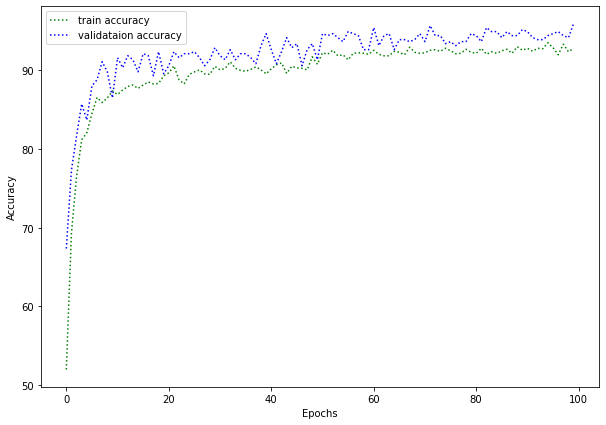

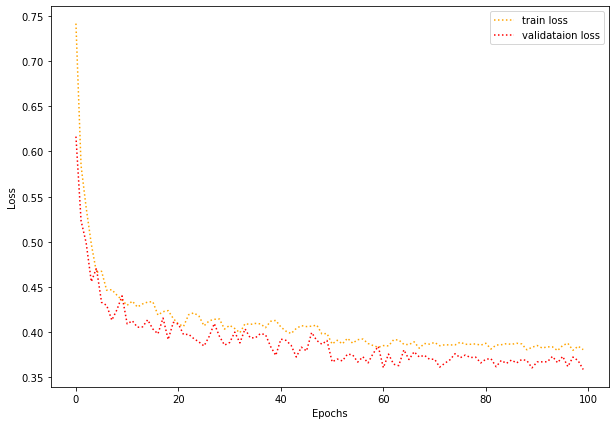

K =  7
[INFO]: Epoch 1 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


Training loss: 0.380, training acc: 92.976
Validation loss: 0.371, validation acc: 93.878
--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


Training loss: 0.379, training acc: 92.209
Validation loss: 0.360, validation acc: 94.898
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


Training loss: 0.377, training acc: 93.487
Validation loss: 0.372, validation acc: 94.133
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


Training loss: 0.379, training acc: 92.848
Validation loss: 0.363, validation acc: 94.643
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


Training loss: 0.380, training acc: 93.103
Validation loss: 0.364, validation acc: 94.898
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


Training loss: 0.379, training acc: 92.656
Validation loss: 0.368, validation acc: 94.388
--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


Training loss: 0.380, training acc: 93.040
Validation loss: 0.357, validation acc: 95.918

Best validation loss: 0.35720229148864746

Saving best model for epoch: 7

--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Training loss: 0.380, training acc: 93.487
Validation loss: 0.364, validation acc: 94.388
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


Training loss: 0.384, training acc: 93.040
Validation loss: 0.369, validation acc: 94.133
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


Training loss: 0.381, training acc: 93.167
Validation loss: 0.362, validation acc: 95.663
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


Training loss: 0.379, training acc: 93.295
Validation loss: 0.366, validation acc: 94.898
--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


Training loss: 0.378, training acc: 93.487
Validation loss: 0.369, validation acc: 94.133
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.74it/s]


Training loss: 0.387, training acc: 92.529
Validation loss: 0.369, validation acc: 94.898
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


Training loss: 0.380, training acc: 92.848
Validation loss: 0.364, validation acc: 94.643
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.71it/s]


Training loss: 0.377, training acc: 93.167
Validation loss: 0.370, validation acc: 93.878
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.42it/s]


Training loss: 0.375, training acc: 93.550
Validation loss: 0.362, validation acc: 94.898
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


Training loss: 0.377, training acc: 93.678
Validation loss: 0.366, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.72it/s]


Training loss: 0.376, training acc: 93.231
Validation loss: 0.358, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


Training loss: 0.376, training acc: 93.231
Validation loss: 0.365, validation acc: 94.643
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


Training loss: 0.382, training acc: 92.529
Validation loss: 0.359, validation acc: 95.918
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


Training loss: 0.379, training acc: 92.784
Validation loss: 0.359, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.33it/s]


Training loss: 0.374, training acc: 93.103
Validation loss: 0.357, validation acc: 95.663
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


Training loss: 0.381, training acc: 92.912
Validation loss: 0.364, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


Training loss: 0.374, training acc: 93.678
Validation loss: 0.364, validation acc: 94.643
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


Training loss: 0.379, training acc: 93.167
Validation loss: 0.366, validation acc: 94.388
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


Training loss: 0.378, training acc: 93.167
Validation loss: 0.358, validation acc: 95.663
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


Training loss: 0.379, training acc: 92.720
Validation loss: 0.361, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


Training loss: 0.380, training acc: 93.359
Validation loss: 0.362, validation acc: 94.643
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


Training loss: 0.383, training acc: 92.976
Validation loss: 0.362, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


Training loss: 0.380, training acc: 92.976
Validation loss: 0.364, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


Training loss: 0.376, training acc: 93.295
Validation loss: 0.356, validation acc: 95.408

Best validation loss: 0.355711966753006

Saving best model for epoch: 31

--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


Training loss: 0.377, training acc: 93.040
Validation loss: 0.356, validation acc: 95.663
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


Training loss: 0.377, training acc: 93.550
Validation loss: 0.367, validation acc: 94.643
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


Training loss: 0.382, training acc: 92.976
Validation loss: 0.358, validation acc: 95.918
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


Training loss: 0.379, training acc: 93.167
Validation loss: 0.369, validation acc: 94.388
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


Training loss: 0.380, training acc: 92.784
Validation loss: 0.359, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


Training loss: 0.383, training acc: 92.529
Validation loss: 0.370, validation acc: 94.133
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


Training loss: 0.378, training acc: 93.359
Validation loss: 0.367, validation acc: 94.388
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.67it/s]


Training loss: 0.383, training acc: 92.337
Validation loss: 0.358, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


Training loss: 0.377, training acc: 93.359
Validation loss: 0.361, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


Training loss: 0.381, training acc: 92.465
Validation loss: 0.360, validation acc: 95.663
--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


Training loss: 0.378, training acc: 93.040
Validation loss: 0.361, validation acc: 94.388
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


Training loss: 0.385, training acc: 93.103
Validation loss: 0.369, validation acc: 94.388
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Training loss: 0.376, training acc: 93.103
Validation loss: 0.357, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


Training loss: 0.374, training acc: 93.997
Validation loss: 0.365, validation acc: 94.898
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


Training loss: 0.378, training acc: 93.487
Validation loss: 0.361, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.31it/s]


Training loss: 0.373, training acc: 93.423
Validation loss: 0.358, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.50it/s]


Training loss: 0.376, training acc: 93.359
Validation loss: 0.358, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


Training loss: 0.384, training acc: 92.784
Validation loss: 0.359, validation acc: 94.898
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


Training loss: 0.382, training acc: 92.529
Validation loss: 0.362, validation acc: 95.408
--------------------------------------------------
Saving final model...


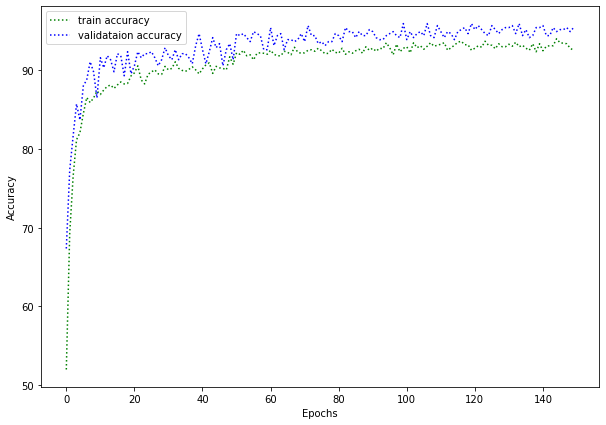

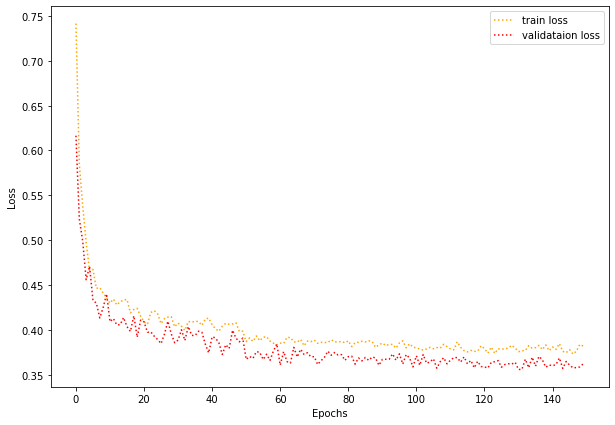

K =  21
[INFO]: Epoch 1 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.26it/s]


Training loss: 0.377, training acc: 93.359
Validation loss: 0.360, validation acc: 94.898
--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


Training loss: 0.372, training acc: 93.742
Validation loss: 0.359, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.47it/s]


Training loss: 0.375, training acc: 93.870
Validation loss: 0.363, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.38it/s]


Training loss: 0.371, training acc: 93.359
Validation loss: 0.359, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


Training loss: 0.374, training acc: 93.103
Validation loss: 0.364, validation acc: 94.898
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


Training loss: 0.379, training acc: 93.423
Validation loss: 0.363, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


Training loss: 0.374, training acc: 93.550
Validation loss: 0.359, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


Training loss: 0.373, training acc: 93.231
Validation loss: 0.360, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


Training loss: 0.378, training acc: 93.167
Validation loss: 0.358, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


Training loss: 0.378, training acc: 93.040
Validation loss: 0.362, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


Training loss: 0.381, training acc: 92.784
Validation loss: 0.358, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


Training loss: 0.377, training acc: 93.167
Validation loss: 0.360, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


Training loss: 0.374, training acc: 93.550
Validation loss: 0.362, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Training loss: 0.376, training acc: 93.040
Validation loss: 0.363, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


Training loss: 0.377, training acc: 93.231
Validation loss: 0.359, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


Training loss: 0.373, training acc: 94.061
Validation loss: 0.359, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


Training loss: 0.374, training acc: 93.550
Validation loss: 0.361, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


Training loss: 0.374, training acc: 93.423
Validation loss: 0.357, validation acc: 95.663
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


Training loss: 0.373, training acc: 93.614
Validation loss: 0.359, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


Training loss: 0.374, training acc: 93.550
Validation loss: 0.362, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


Training loss: 0.380, training acc: 93.167
Validation loss: 0.360, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Training loss: 0.373, training acc: 92.912
Validation loss: 0.359, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


Training loss: 0.375, training acc: 93.742
Validation loss: 0.362, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


Training loss: 0.376, training acc: 93.359
Validation loss: 0.359, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


Training loss: 0.378, training acc: 93.040
Validation loss: 0.362, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


Training loss: 0.374, training acc: 93.550
Validation loss: 0.359, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


Training loss: 0.375, training acc: 93.614
Validation loss: 0.358, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


Training loss: 0.373, training acc: 93.614
Validation loss: 0.362, validation acc: 94.643
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


Training loss: 0.379, training acc: 93.167
Validation loss: 0.359, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


Training loss: 0.378, training acc: 93.487
Validation loss: 0.359, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.47it/s]


Training loss: 0.381, training acc: 93.614
Validation loss: 0.360, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.56it/s]


Training loss: 0.377, training acc: 93.487
Validation loss: 0.361, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


Training loss: 0.376, training acc: 93.742
Validation loss: 0.360, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


Training loss: 0.381, training acc: 93.103
Validation loss: 0.360, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


Training loss: 0.370, training acc: 93.614
Validation loss: 0.361, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


Training loss: 0.374, training acc: 93.806
Validation loss: 0.360, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Training loss: 0.372, training acc: 93.423
Validation loss: 0.363, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


Training loss: 0.376, training acc: 93.295
Validation loss: 0.360, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


Training loss: 0.372, training acc: 93.806
Validation loss: 0.358, validation acc: 95.663
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.78it/s]


Training loss: 0.377, training acc: 93.678
Validation loss: 0.360, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


Training loss: 0.373, training acc: 93.423
Validation loss: 0.358, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


Training loss: 0.373, training acc: 93.614
Validation loss: 0.359, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


Training loss: 0.378, training acc: 93.550
Validation loss: 0.358, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Training loss: 0.376, training acc: 93.614
Validation loss: 0.360, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


Training loss: 0.374, training acc: 94.253
Validation loss: 0.362, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.74it/s]


Training loss: 0.375, training acc: 93.742
Validation loss: 0.361, validation acc: 95.153
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


Training loss: 0.377, training acc: 93.614
Validation loss: 0.360, validation acc: 95.408
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  6.61it/s]


Training loss: 0.376, training acc: 93.678
Validation loss: 0.364, validation acc: 94.898
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Training loss: 0.377, training acc: 93.295
Validation loss: 0.361, validation acc: 94.898
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Validation


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


Training loss: 0.375, training acc: 93.103
Validation loss: 0.360, validation acc: 95.408
--------------------------------------------------
Saving final model...


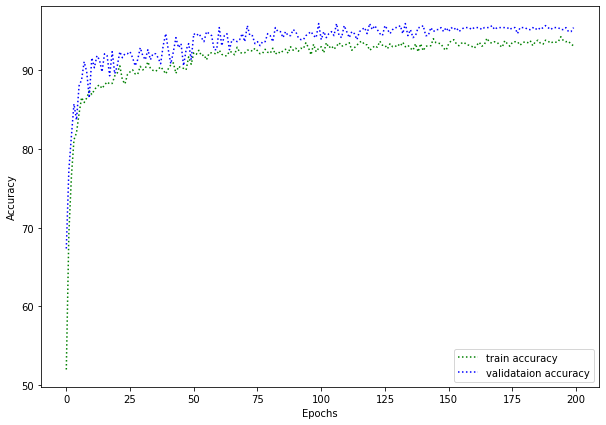

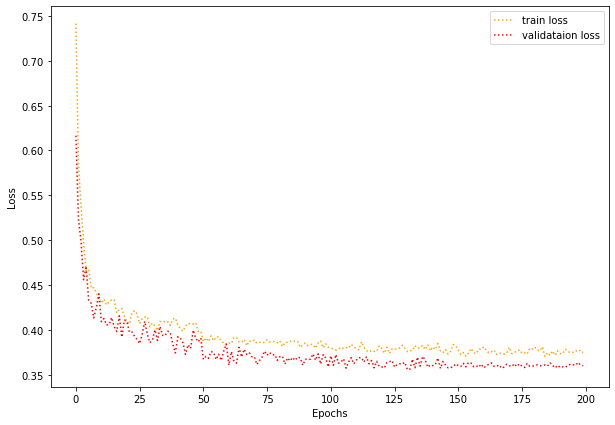

K =  255
[INFO]: Epoch 1 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Training loss: 0.381, training acc: 93.423
Validation loss: 0.543, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Training loss: 0.374, training acc: 93.295
Validation loss: 0.549, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


100%|██████████| 2/2 [00:05<00:00,  2.80s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Training loss: 0.376, training acc: 93.103
Validation loss: 0.544, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


100%|██████████| 2/2 [00:04<00:00,  2.37s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Training loss: 0.384, training acc: 92.784
Validation loss: 0.525, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Training loss: 0.383, training acc: 92.656
Validation loss: 0.550, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


100%|██████████| 2/2 [00:05<00:00,  2.58s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Training loss: 0.387, training acc: 92.465
Validation loss: 0.544, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.88s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Training loss: 0.385, training acc: 92.656
Validation loss: 0.520, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


Training loss: 0.378, training acc: 93.040
Validation loss: 0.524, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.84s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Training loss: 0.388, training acc: 92.465
Validation loss: 0.536, validation acc: 83.929
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Training loss: 0.383, training acc: 92.912
Validation loss: 0.535, validation acc: 83.929
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Training loss: 0.381, training acc: 93.040
Validation loss: 0.522, validation acc: 83.929
--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Training loss: 0.380, training acc: 92.720
Validation loss: 0.525, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Training loss: 0.375, training acc: 93.231
Validation loss: 0.553, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Training loss: 0.378, training acc: 93.231
Validation loss: 0.546, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Training loss: 0.388, training acc: 92.273
Validation loss: 0.530, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.83s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Training loss: 0.381, training acc: 93.040
Validation loss: 0.540, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


100%|██████████| 2/2 [00:04<00:00,  2.16s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Training loss: 0.380, training acc: 93.103
Validation loss: 0.549, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Training loss: 0.390, training acc: 92.529
Validation loss: 0.548, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


Training loss: 0.378, training acc: 92.912
Validation loss: 0.523, validation acc: 83.929
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


100%|██████████| 2/2 [00:04<00:00,  2.10s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Training loss: 0.382, training acc: 92.465
Validation loss: 0.538, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Training loss: 0.375, training acc: 93.231
Validation loss: 0.535, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Training loss: 0.378, training acc: 93.295
Validation loss: 0.521, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Training loss: 0.377, training acc: 93.231
Validation loss: 0.518, validation acc: 83.929
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


100%|██████████| 2/2 [00:04<00:00,  2.37s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Training loss: 0.389, training acc: 92.784
Validation loss: 0.527, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


100%|██████████| 2/2 [00:04<00:00,  2.34s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Training loss: 0.377, training acc: 93.167
Validation loss: 0.550, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Training loss: 0.382, training acc: 93.295
Validation loss: 0.536, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Training loss: 0.388, training acc: 92.656
Validation loss: 0.529, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Training loss: 0.379, training acc: 93.103
Validation loss: 0.524, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Training loss: 0.378, training acc: 93.614
Validation loss: 0.512, validation acc: 83.929
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Training loss: 0.374, training acc: 93.742
Validation loss: 0.523, validation acc: 83.929
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Training loss: 0.377, training acc: 93.423
Validation loss: 0.516, validation acc: 83.929
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Training loss: 0.375, training acc: 93.167
Validation loss: 0.519, validation acc: 83.929
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Training loss: 0.378, training acc: 93.231
Validation loss: 0.509, validation acc: 83.929
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Training loss: 0.378, training acc: 93.167
Validation loss: 0.502, validation acc: 83.929
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Training loss: 0.382, training acc: 92.656
Validation loss: 0.502, validation acc: 83.929
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Training loss: 0.378, training acc: 93.167
Validation loss: 0.504, validation acc: 84.184
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Training loss: 0.374, training acc: 93.231
Validation loss: 0.515, validation acc: 83.929
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Training loss: 0.379, training acc: 93.103
Validation loss: 0.521, validation acc: 83.929
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Training loss: 0.379, training acc: 93.167
Validation loss: 0.522, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Training loss: 0.378, training acc: 93.295
Validation loss: 0.524, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Training loss: 0.385, training acc: 92.848
Validation loss: 0.519, validation acc: 83.929
--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Training loss: 0.383, training acc: 92.976
Validation loss: 0.518, validation acc: 83.929
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Training loss: 0.376, training acc: 92.912
Validation loss: 0.524, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Training loss: 0.375, training acc: 93.487
Validation loss: 0.525, validation acc: 83.929
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Training loss: 0.375, training acc: 93.167
Validation loss: 0.540, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Training loss: 0.380, training acc: 92.720
Validation loss: 0.542, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Training loss: 0.377, training acc: 93.359
Validation loss: 0.538, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Training loss: 0.378, training acc: 93.167
Validation loss: 0.532, validation acc: 83.673
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Training loss: 0.373, training acc: 93.103
Validation loss: 0.535, validation acc: 83.929
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


Validation


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Training loss: 0.377, training acc: 93.167
Validation loss: 0.523, validation acc: 83.673
--------------------------------------------------
Saving final model...


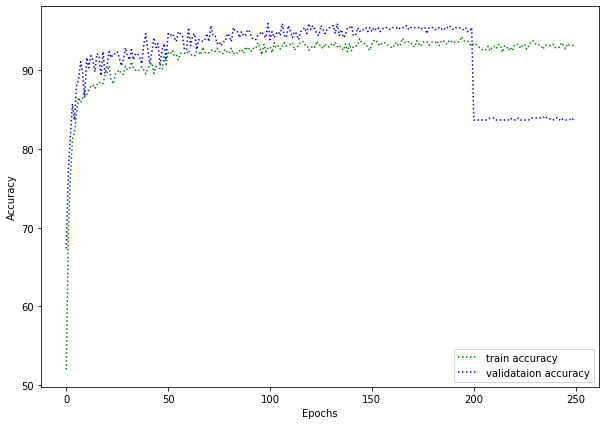

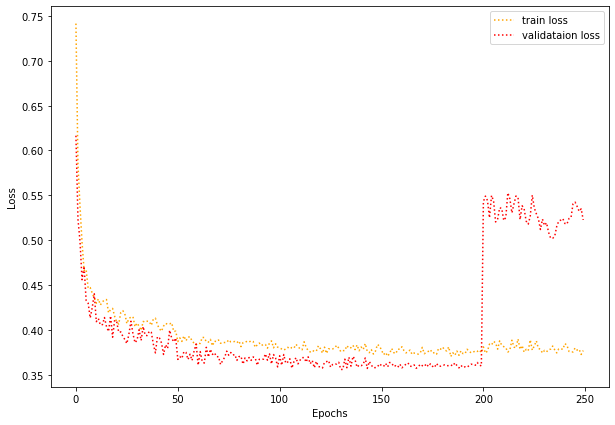

TRAINING COMPLETE


In [32]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
epochs = 50
k_list = [3,5,7,21, 255]
# start the training
for k in k_list:
    print("K = ",k)
    for epoch in range(epochs):
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")
        #optimizer = exp_lr_scheduler(optimizer_ft, epochs)
        train_epoch_loss, train_epoch_acc = train(model, train_loader,optimizer_ft, criterion,k)
        valid_epoch_loss, valid_epoch_acc = validate(model, val_loader,criterion,k)
        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        train_acc.append(train_epoch_acc)
        valid_acc.append(valid_epoch_acc)
        print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
        print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
        # save the best model till now if we have the least loss in the current epoch
        save_best_model(valid_epoch_loss, epoch, model, optimizer_ft, criterion,k)
        print('-'*50)
    
    # save the trained model weights for a final time
    save_model(epochs, model, optimizer_ft, criterion)
    # save the loss and accuracy plots
    save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

In [34]:
# Test the model on test samples

confusion_matrix = torch.zeros(NUM_CLASSES, NUM_CLASSES)
for k in k_list:
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            inputs = inputs.squeeze()
            adj_matrix = nearestneighbours(inputs,k)
            adj_matrix = adj_matrix.to(device)
            edge = edge_finder(adj_matrix)
            feats = model(inputs.unsqueeze(0),adj_matrix.unsqueeze(0), edge, 1)
            outputs = model(feats, adj_matrix, edge, 0)
            outputs = outputs.squeeze()
            fl_pred = outputs.argmax(dim=1)
        
            p=precision_score(classes.cpu(), fl_pred.cpu(), average="micro", zero_division= False)
            r=recall_score(classes.cpu(), fl_pred.cpu(), average="micro", zero_division= False)
            f=f1_score(classes.cpu(), fl_pred.cpu(), average="micro", zero_division= False)
            print('F1: {}'.format(f))
            print('Precision: {}'.format(p))
            print('Recall: {}'.format(r))
            print(classification_report(classes.cpu(),fl_pred.cpu()))

F1: 0.936
Precision: 0.936
Recall: 0.936
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       250
           1       0.93      0.94      0.94       250

    accuracy                           0.94       500
   macro avg       0.94      0.94      0.94       500
weighted avg       0.94      0.94      0.94       500

F1: 0.956
Precision: 0.956
Recall: 0.956
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       250
           1       0.95      0.97      0.96       250

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500

F1: 0.944
Precision: 0.944
Recall: 0.944
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       250
           1       0.95      0.94      0.94       250

    accuracy                           0.94       500
   ma

K =  3
Accuracy on test data: 0.934
Precison:  0.948
Recall:  0.9221789883268483
F1-Score : 0.9349112426035503


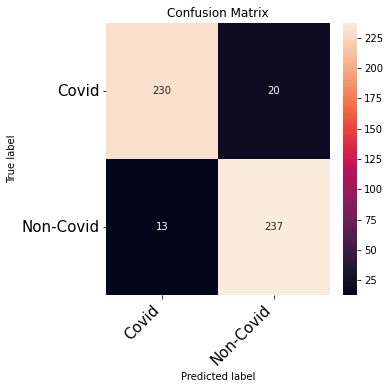

K =  5
Accuracy on test data: 0.945
Precison:  0.964
Recall:  0.9488188976377953
F1-Score : 0.9563492063492063


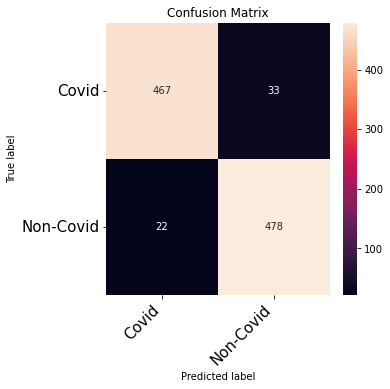

K =  7
Accuracy on test data: 0.9473333333333334
Precison:  0.956
Recall:  0.9484126984126984
F1-Score : 0.952191235059761


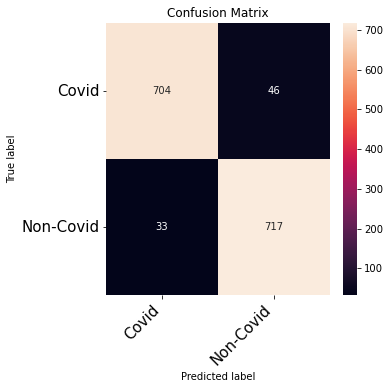

K =  21
Accuracy on test data: 0.9485
Precison:  0.96
Recall:  0.9448818897637795
F1-Score : 0.9523809523809523


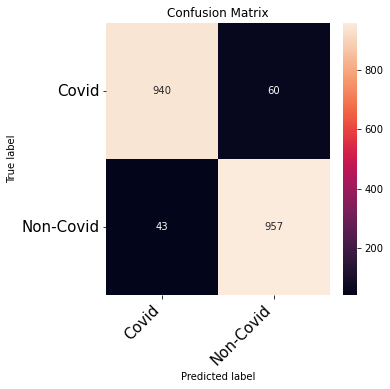

K =  255
Accuracy on test data: 0.9472
Precison:  0.932
Recall:  0.9510204081632653
F1-Score : 0.9414141414141414


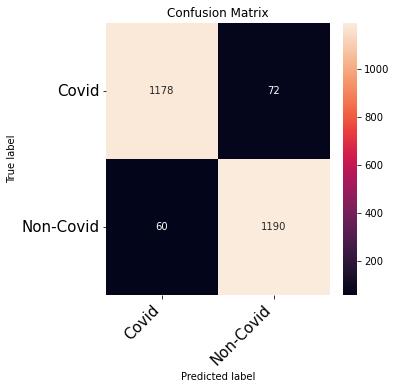

In [35]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

confusion_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES))
for k in k_list:
        print("K = ",k)
        with torch.no_grad():
                for i, (inputs, classes) in enumerate(test_loader):
                        inputs = inputs.to(device)
                        classes = classes.to(device)
                        inputs = inputs.squeeze()
                        adj_matrix = nearestneighbours(inputs,k)
                        adj_matrix = adj_matrix.to(device)
                        edge = edge_finder(adj_matrix)
                        feats =  model(inputs.unsqueeze(0),adj_matrix.unsqueeze(0), edge, 1)
                        outputs = model(feats, adj_matrix, edge, 0)
                        outputs = outputs.squeeze()
                        _, preds = torch.max(outputs, 1)
            
                        for t, p in zip(classes.view(-1), preds.view(-1)):
                                confusion_matrix[t.long(), p.long()] += 1
                
        print(f"Accuracy on test data: {confusion_matrix.diagonal().sum()/confusion_matrix.sum()}")
        print("Precison: ", precision_score(preds, classes))
        print("Recall: ",recall_score(preds, classes))
        print("F1-Score :", f1_score(preds, classes))
        plt.figure(figsize=(5,5))

        class_names = ['Covid','Non-Covid']
        df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title('Confusion Matrix')
        plt.show()

In [100]:
torch.save(model,'ResGnn.pt')